In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression

In [2]:
import warnings
import logging

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.ERROR)

In [3]:
# Load your JSON data
filename = 'stock_data_final.json'
with open(filename, 'r') as f:
    data = json.load(f)

Processing data for HDFCBANK
Forecasted Quarters Revenue for HDFCBANK:  [83082.52986022 86730.98009311 90379.35070039 94027.64168382]


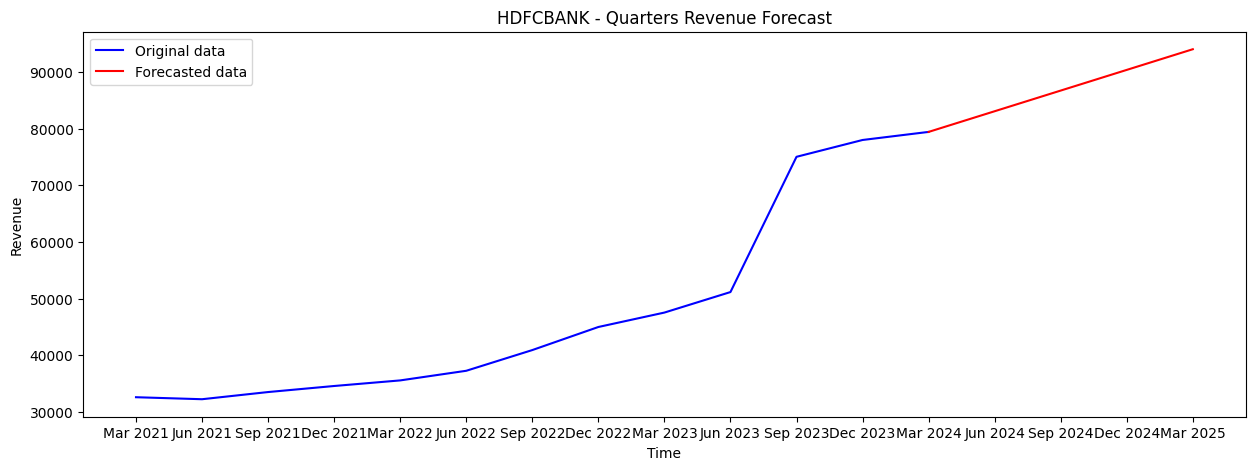

Forecasted Quarters Net Profit for HDFCBANK:  [17654.13260765 18012.9684489  17654.16415598 18012.93690334]


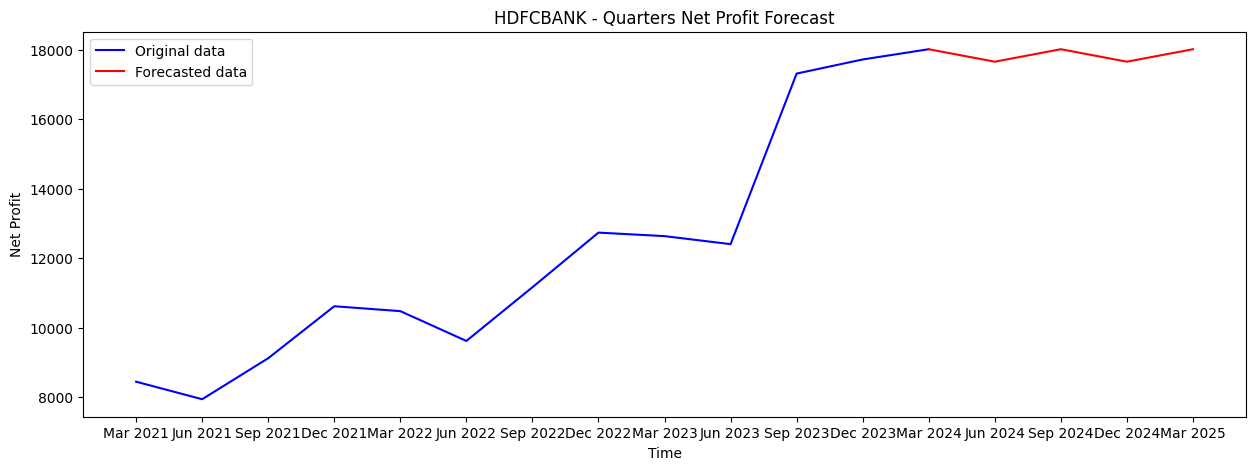

Forecasted Annual Revenue for HDFCBANK:  [447567.27560715 611485.50755039 775403.69582972 939321.84044515]


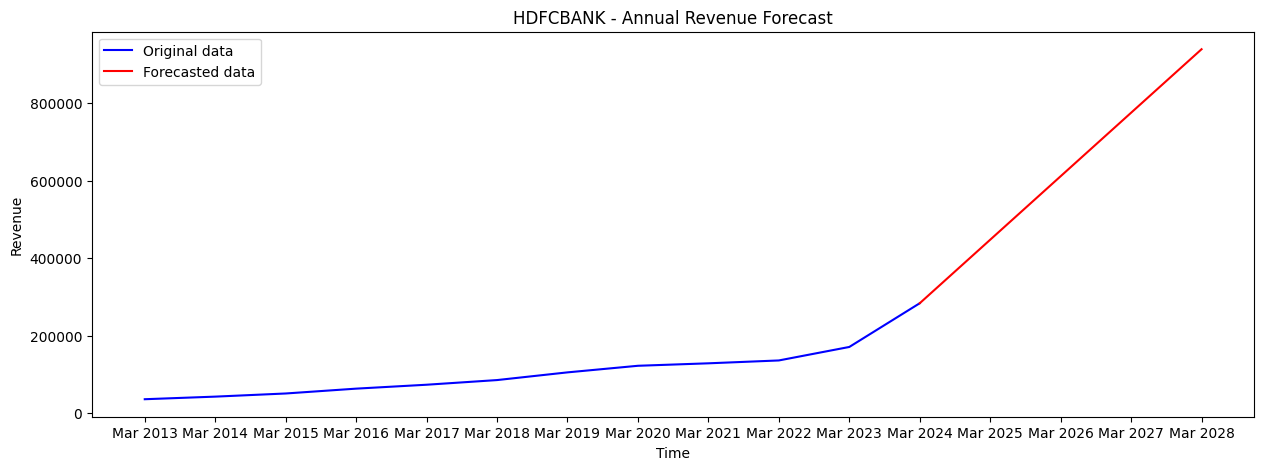

Forecasted Annual Net Profit for HDFCBANK:  [ 88483.20303033 111520.40591238 134557.60864616 157594.81123167]


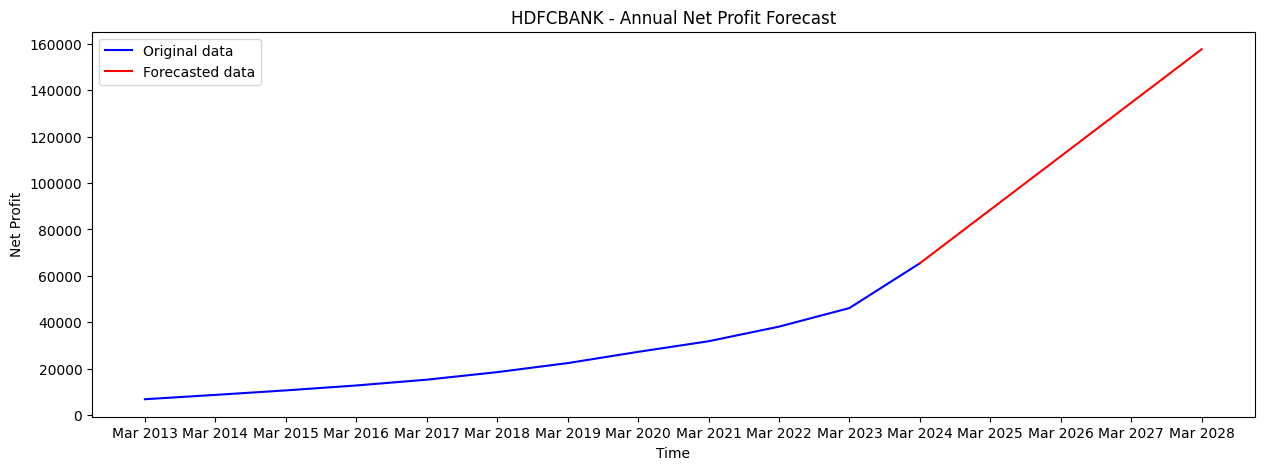

In [7]:
def forecast(stock, time_period):
    # Extract the revenue data for quarters and annual
    timeline = data[stock][time_period]['Headers']
    revenue = data[stock][time_period]['Revenue']
    net_profit = data[stock][time_period]['Net Profit']

    # Parse the string data to integers
    revenue = [int(rev.replace(',', '')) for rev in revenue]
    net_profit = [int(rev.replace(',', '')) for rev in net_profit]

    n = 4  # number of future points to predict
    forecast_timeline = [timeline[-1]]
    for i in range(n):
        prev_time = timeline[-1 - 3 + i]
        month, year = prev_time.split(' ')
        upcoming_year = int(year) + 1 if time_period == 'Quarters' else int(year) + 4
        next_time = ' '.join([month, str(upcoming_year)])
        forecast_timeline.append(next_time)

    # Forecasting for Revenue
    model = ARIMA(revenue, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=n)
    print(f"Forecasted {time_period} Revenue for {stock}: ", forecast.predicted_mean)

    # Plot original data
    plt.figure(figsize=(15, 5))
    plt.plot(timeline, revenue, color='blue', label='Original data')

    # Insert last original value to forcasted data
    forecasted_values = [revenue[-1]]
    forecasted_values.extend(forecast.predicted_mean)
    
    # Plot forecasted data with the last original point
    plt.plot(forecast_timeline, forecasted_values, color='red', label='Forecasted data')
    
    plt.title(f'{stock} - {time_period} Revenue Forecast')
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    plt.legend()
    plt.show()
    
    # Forecasting for Net Profit
    model = ARIMA(net_profit, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=n)
    print(f"Forecasted {time_period} Net Profit for {stock}: ", forecast.predicted_mean)

    # Plot original data
    plt.figure(figsize=(15, 5))
    plt.plot(timeline, net_profit, color='blue', label='Original data')

    # Insert last original value to forcasted data
    forecasted_values = [net_profit[-1]]
    forecasted_values.extend(forecast.predicted_mean)
    
    # Plot forecasted data with the last original point
    plt.plot(forecast_timeline, forecasted_values, color='red', label='Forecasted data')
    
    plt.title(f'{stock} - {time_period} Net Profit Forecast')
    plt.xlabel('Time')
    plt.ylabel('Net Profit')
    plt.legend()
    plt.show()

for stock in data.keys():
    print(f"Processing data for {stock}")

    try:
        forecast(stock, 'Quarters')
        forecast(stock, 'Annual')
    except:
        print(f"Could not process {stock} data completely")

    break

Forecasted Revenue: [79434, 86762, 114853, 120994]


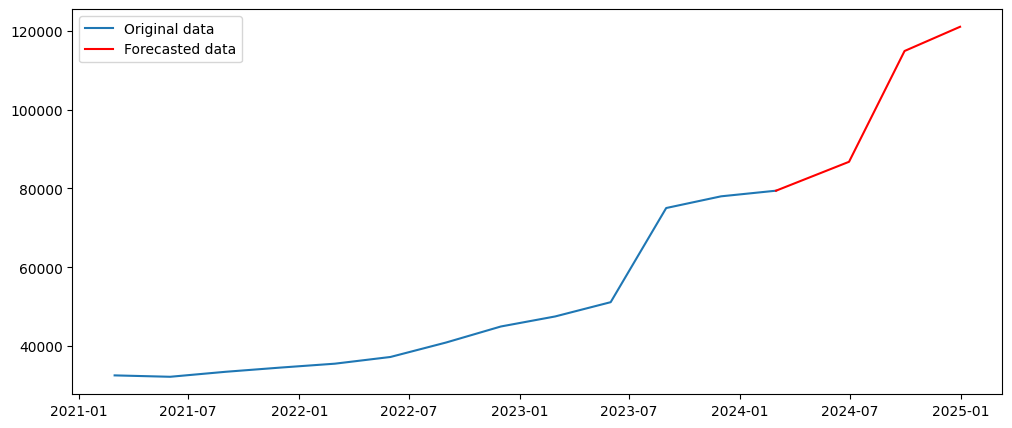

In [5]:
# Prepare the data
quarters_df = pd.DataFrame({
    'ds': pd.to_datetime(data['HDFCBANK']['Quarters']['Headers']),
    'y': [int(rev.replace(',', '')) for rev in data['HDFCBANK']['Quarters']['Revenue']]
})

# Specify the order of the model (p, d, q)(P, D, Q, m)
model = SARIMAX(quarters_df['y'], order=(1,1,1), seasonal_order=(1,1,1,4))

# Fit the model
model_fit = model.fit(disp=0)

# Make a future prediction
n = 3  # number of future points to predict
forecast = model_fit.get_forecast(steps=n)

# Create a time series for the forecasted data
forecasted_time = pd.date_range(start=quarters_df['ds'].iloc[-1], periods=n+1, freq='Q')[1:]  # start from the next quarter

# Create a series for the forecasted values
forecasted_values = forecast.predicted_mean

# Append the last actual value and time to the forecasted values and time
last_actual_time = quarters_df['ds'].iloc[-1]
last_actual_value = quarters_df['y'].iloc[-1]

forecasted_time = pd.to_datetime([last_actual_time] + list(forecasted_time))
forecasted_values = np.concatenate(([last_actual_value], forecasted_values))

# Print the forecasted values
print('Forecasted Revenue: [', end = '')
for val in forecasted_values[:-1]:
    print(int(val), end=', ')
print(f'{int(forecasted_values[-1])}]')

# Now, plot the graph again
plt.figure(figsize=(12, 5))
plt.plot(quarters_df['ds'], quarters_df['y'], label='Original data')
plt.plot(forecasted_time, forecasted_values, color='red', label='Forecasted data')

plt.legend()
plt.show()

[79434, 77042, 87591, 100530]


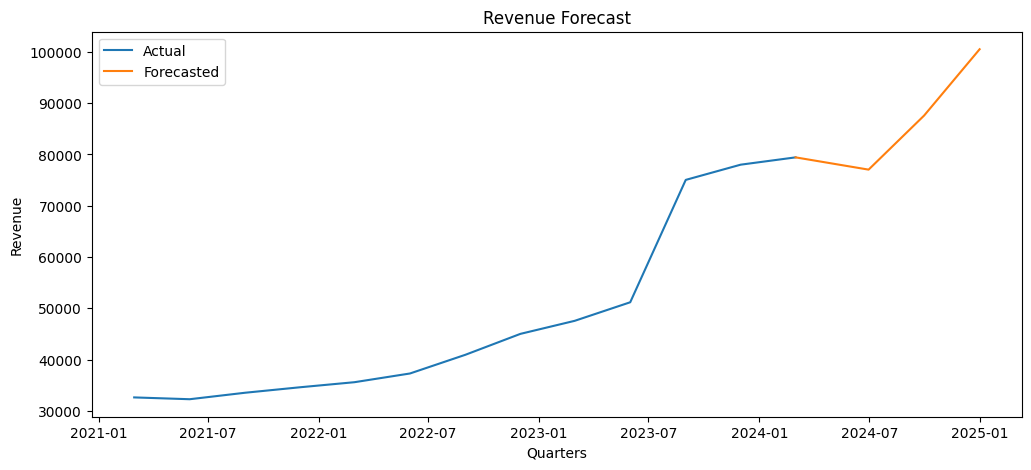

In [6]:
def forecast_revenue(revenues, n, k):
    model = LinearRegression()

    for _ in range(k):
        X_train = np.array(range(len(revenues[-n:]))).reshape(-1,1)
        y_train = np.array(revenues[-n:]).reshape(-1,1)
        model.fit(X_train, y_train)

        X_test = np.array(len(revenues)).reshape(-1,1)
        forecasted_revenue = model.predict(X_test)

        # Append the forecasted revenue to the original list
        revenues.append(int(forecasted_revenue[0][0]))

    return revenues

timeline = pd.to_datetime(data['HDFCBANK']['Quarters']['Headers'])
revenues = [int(rev.replace(',', '')) for rev in data['HDFCBANK']['Quarters']['Revenue']]
n = len(revenues)
k = 3
forecasted_revenues = forecast_revenue(revenues, n, k)
print(forecasted_revenues[n-1:])

# Extend timeline for forecasted quarters assuming each quarter is 3 months apart
forecast_timeline = pd.date_range(start=timeline[-1], periods=k+1, freq='Q')[1:]
timeline = timeline.append(forecast_timeline)

# Plotting
plt.figure(figsize=(12,5))
plt.plot(timeline[:n], revenues[:n], label='Actual')
plt.plot(timeline[n-1:], forecasted_revenues[n-1:], label='Forecasted')  # n-1 to include the last actual point in forecast plot
plt.xlabel('Quarters')
plt.ylabel('Revenue')
plt.title('Revenue Forecast')
plt.legend()
plt.show()